# Using the GCF annotation
## Similar to hg38 (here using mRNA.peak sequence )
## Going to do both nucleotide frequency and the motifs in one notebook

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../parameters/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

tissues = doc["global"]['TISSUES']
supplemental = doc["global"]["SUPPLEMENTAL_DIR"]
#sys.path.append(doc['pipeline_path'])

import time
import os
from os.path import join, basename
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from tss.utils.Homer import *
from tss.data.data_io import shift_bed

import helper
print('Number of tissues: ',len(tissues))

os.chdir(doc["results"])

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


params {'PREFIX': 'ncbi_pice_103', 'ROOT_DIR': '/data/isshamie/TSS/', 'DATA_DIR': '/data/isshamie/TSS/NCBI_PICR_103_Processed/', 'DATA_PROCESSED_DIR': '/data/isshamie/TSS/TSS/data/processed/', 'SUPPLEMENTAL_DIR': '/data/isshamie/TSS/Analysis/supplemental/', 'PIPELINE': '/data/isshamie/TSS/tss', 'GENOME_DIR': '/data/isshamie/genome', 'GENOME_FA': '/data/isshamie/genome/picr.fa', 'GENOME_GFF3': '/data/isshamie/genome/updated_final_sort.gff3', 'GENOME_GTF': '/data/isshamie/genome/updated_final_sort.gtf', 'TISSUES': 'BMDM1hKLA,BMDMwt,Brain,FemaleReproductive,Heart,Intestine,', 'META_FILE': '/data/isshamie/TSS/TSS/parameters/raw_metaSamples.tsv'}
/data2/resources/software/homer/v4.11_10242019/bin//
Number of tissues:  16


In [18]:
from tss import motif_analysis

In [2]:
#import motif_analysis

In [3]:
homer_path =  "/data2/resources/software/homer/v4.11_10242019/bin/"
os.environ['PATH'] = f"{homer_path}:{os.environ['PATH']}"
!which homer

/data2/resources/software/homer/v4.11_10242019/bin//homer


## Input

In [4]:
ref_fa = doc["GENOME_FA"]

anno_gff = '/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff'
mRNA_peak_file = "GCF/genome/mRNA.peak"
mRNA_bed_file = "GCF/genome/mRNA.peak.bed"
tss_annotation = 'GCF/genome/start_site_mRNA.tsv'
seq_f = "GCF/genome/mRNA_150.tss.fa"
peak_f = "GCF/genome/mRNA_150.tss.bed"

## Outdirs

In [5]:
nucleotide_out = "gcf_nucleotide"
motif_out = "gcf_motif_from_meme"

if not os.path.exists(nucleotide_out):
    os.mkdir(nucleotide_out)
    
if not os.path.exists(motif_out):
    os.mkdir(motif_out)

# Nucleotide Sequences of RefSeq TSS

annotatePeaks.pl GCF/genome/mRNA.peak /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -size 200 -hist 1 -di > gcf_nucleotide/gcf_nucfreq_nucl


No handles with labels found to put in legend.


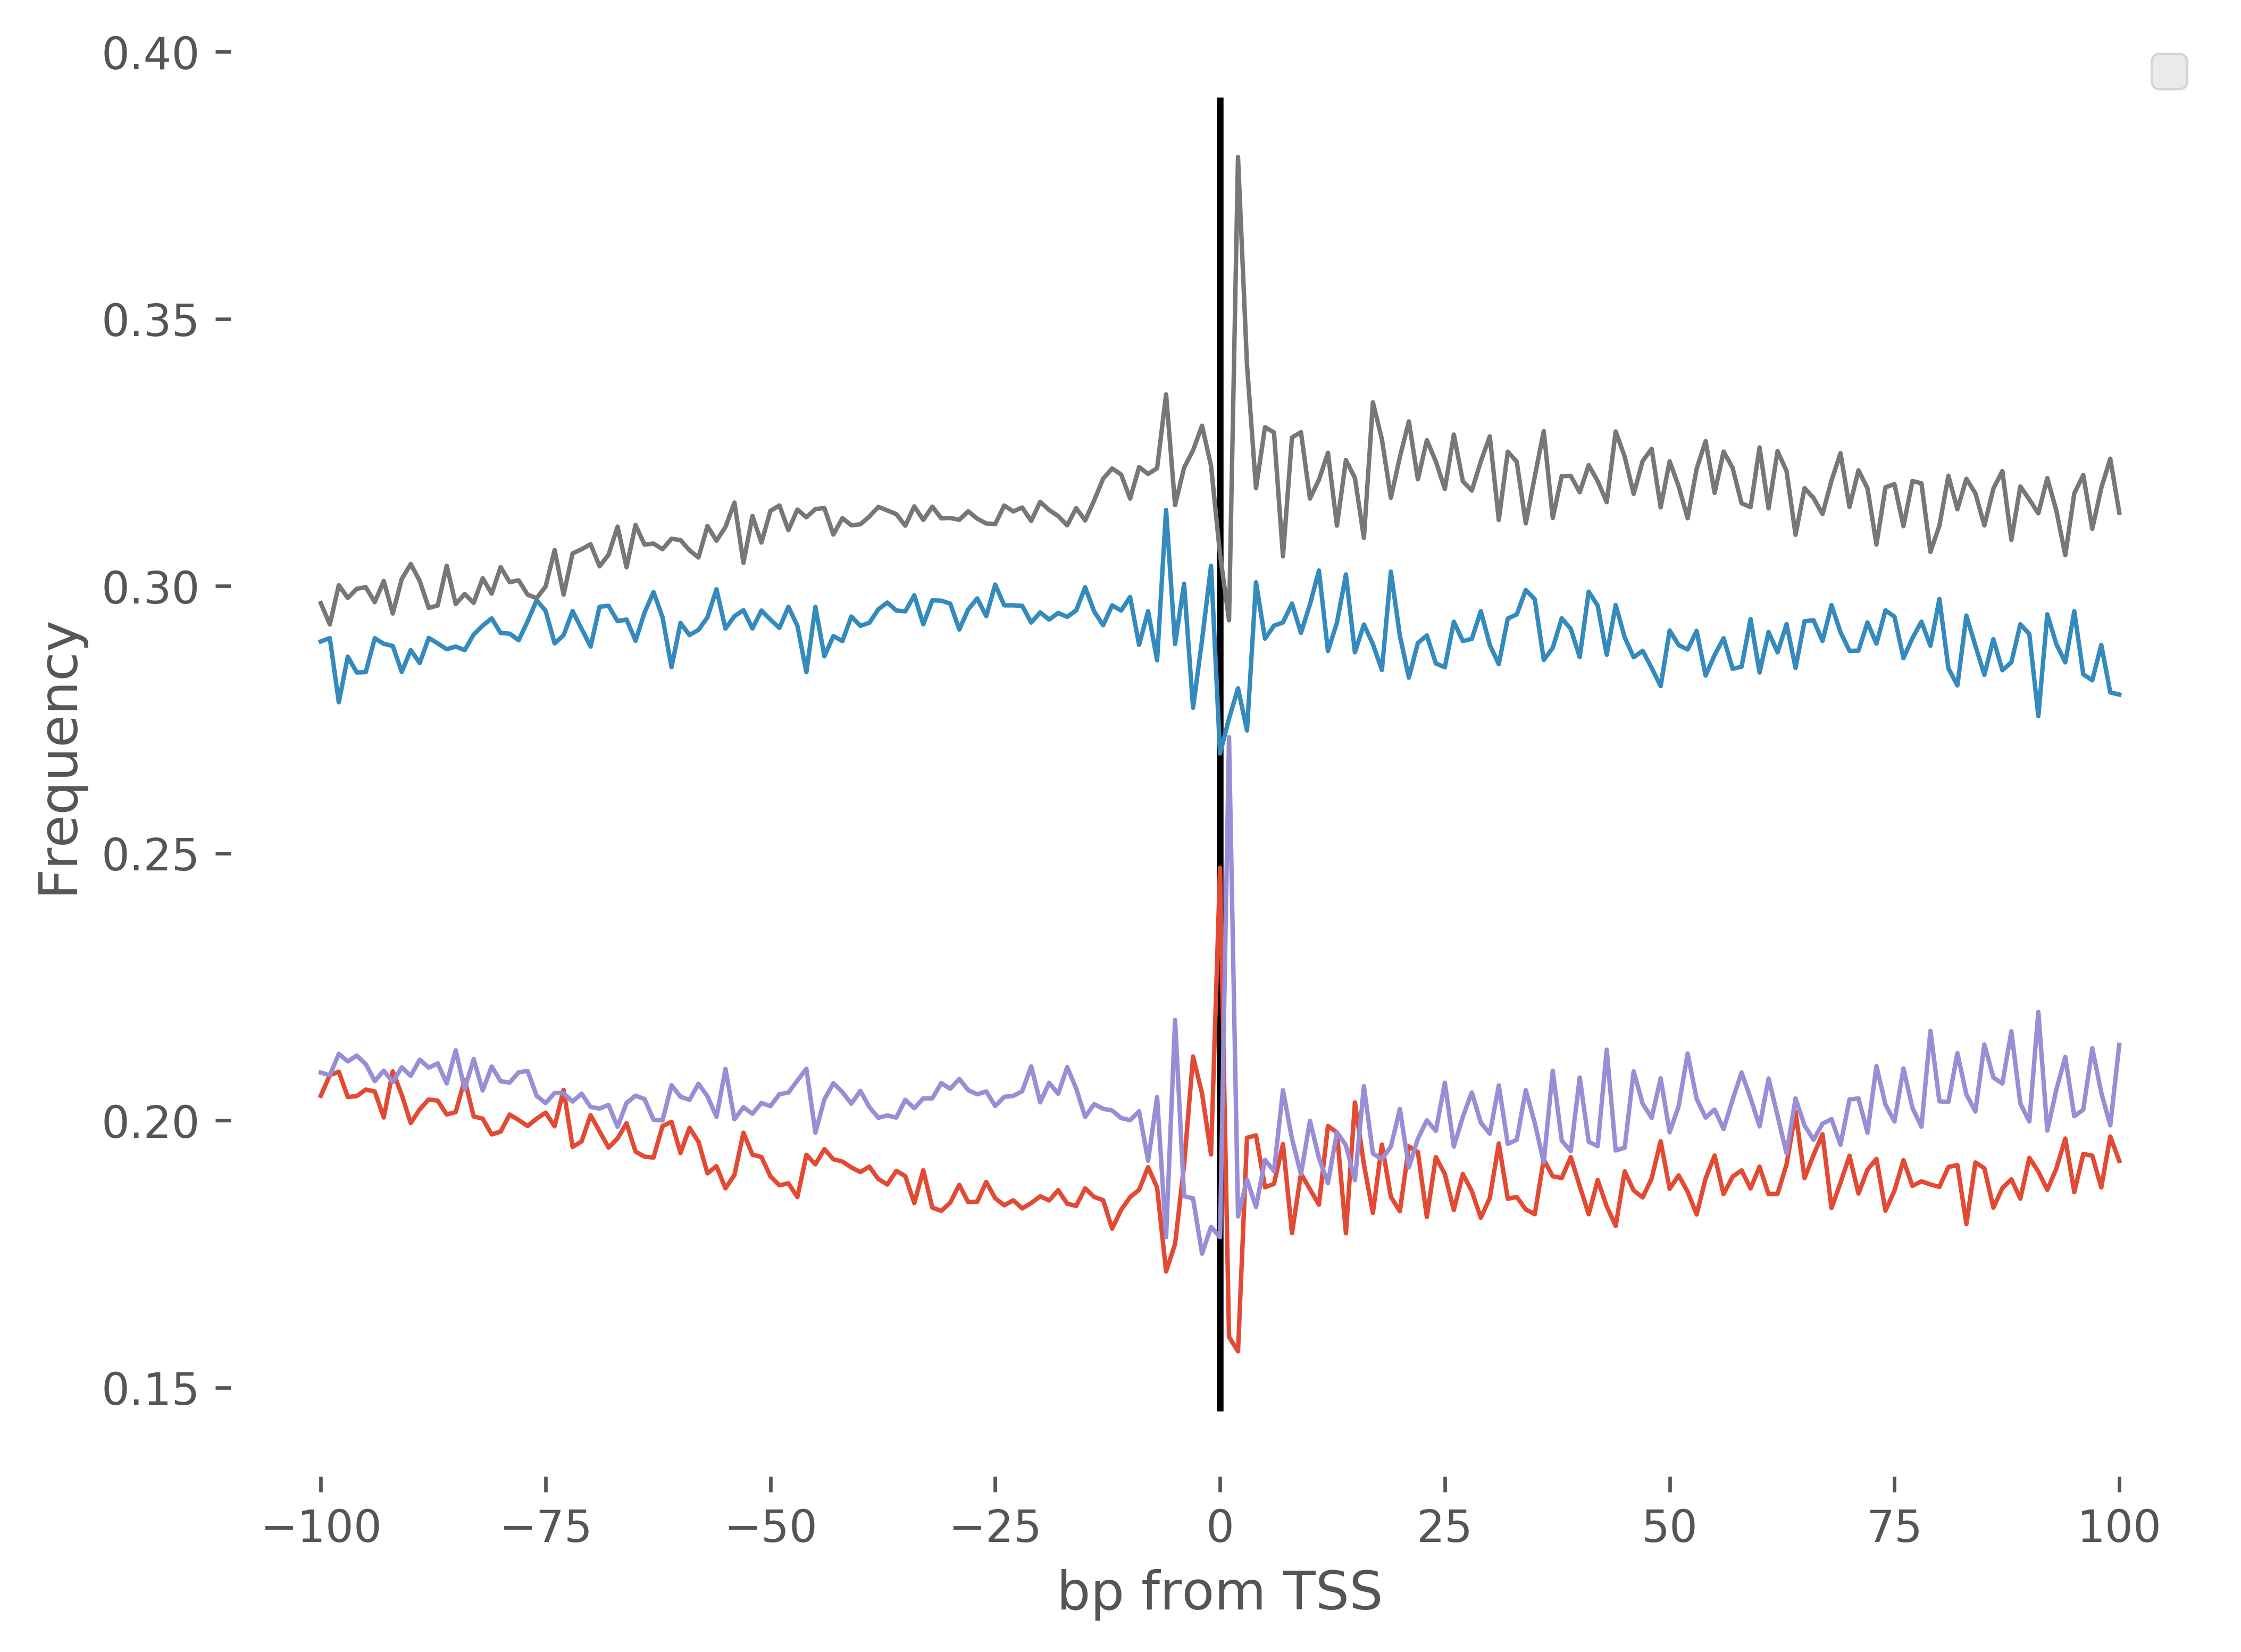

In [6]:
homer_nucleotide(mRNA_peak_file,
    join(nucleotide_out,'gcf_nucfreq_nucl'),
    ref_fa,
    size=200)

## Test by treating as a .bed file (without actually changing into bed

cp GCF/genome/mRNA.peak gcf_nucleotide/mRNA.MOCK.bed
annotatePeaks.pl gcf_nucleotide/mRNA.MOCK.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -size 200 -hist 1 -di > gcf_nucleotide/gcf_nucfreq_nucl_MOCK_BED


No handles with labels found to put in legend.


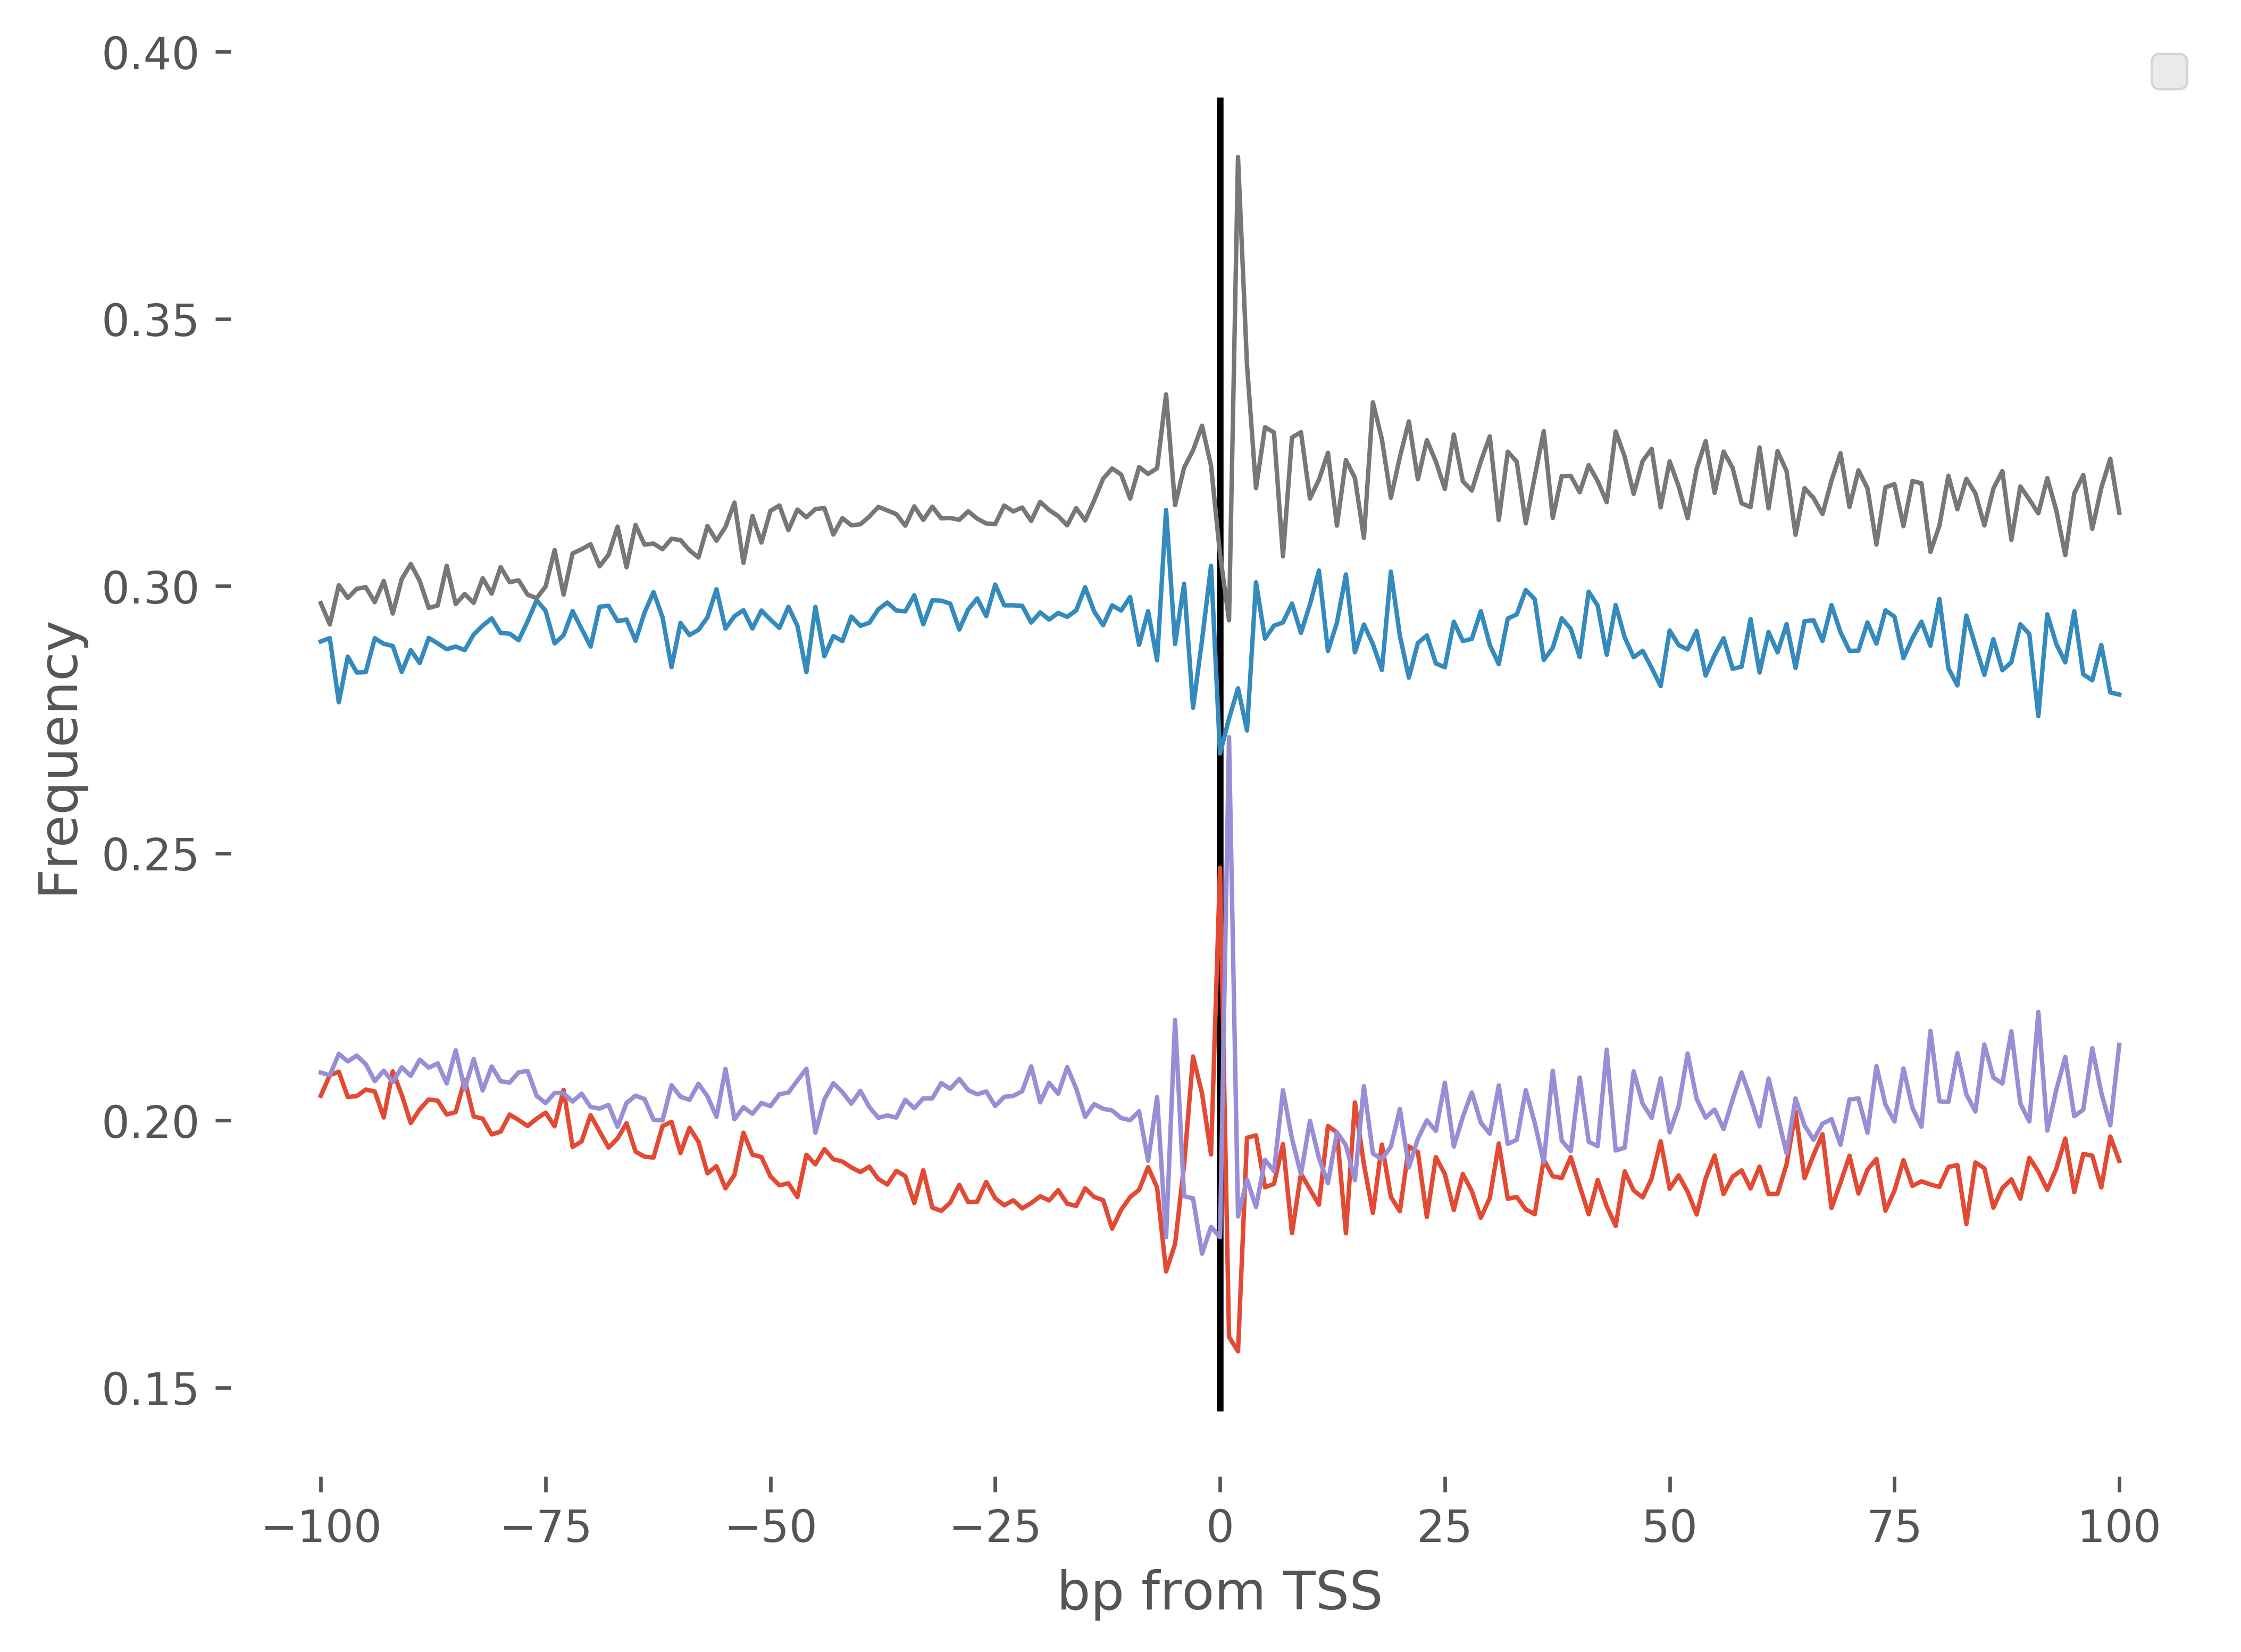

In [7]:
mRNA_mock_bed = join(nucleotide_out,"mRNA.MOCK.bed")
cmd = f"cp {mRNA_peak_file} {mRNA_mock_bed}"
print(cmd)
os.system(cmd)
homer_nucleotide(mRNA_mock_bed,
    join(nucleotide_out,'gcf_nucfreq_nucl_MOCK_BED'),
    ref_fa,
    size=200)

## Last try: Test with actual bed file

annotatePeaks.pl GCF/genome/mRNA.peak.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -size 200 -hist 1 -di > gcf_nucleotide/gcf_nucfreq_nucl_BED


No handles with labels found to put in legend.


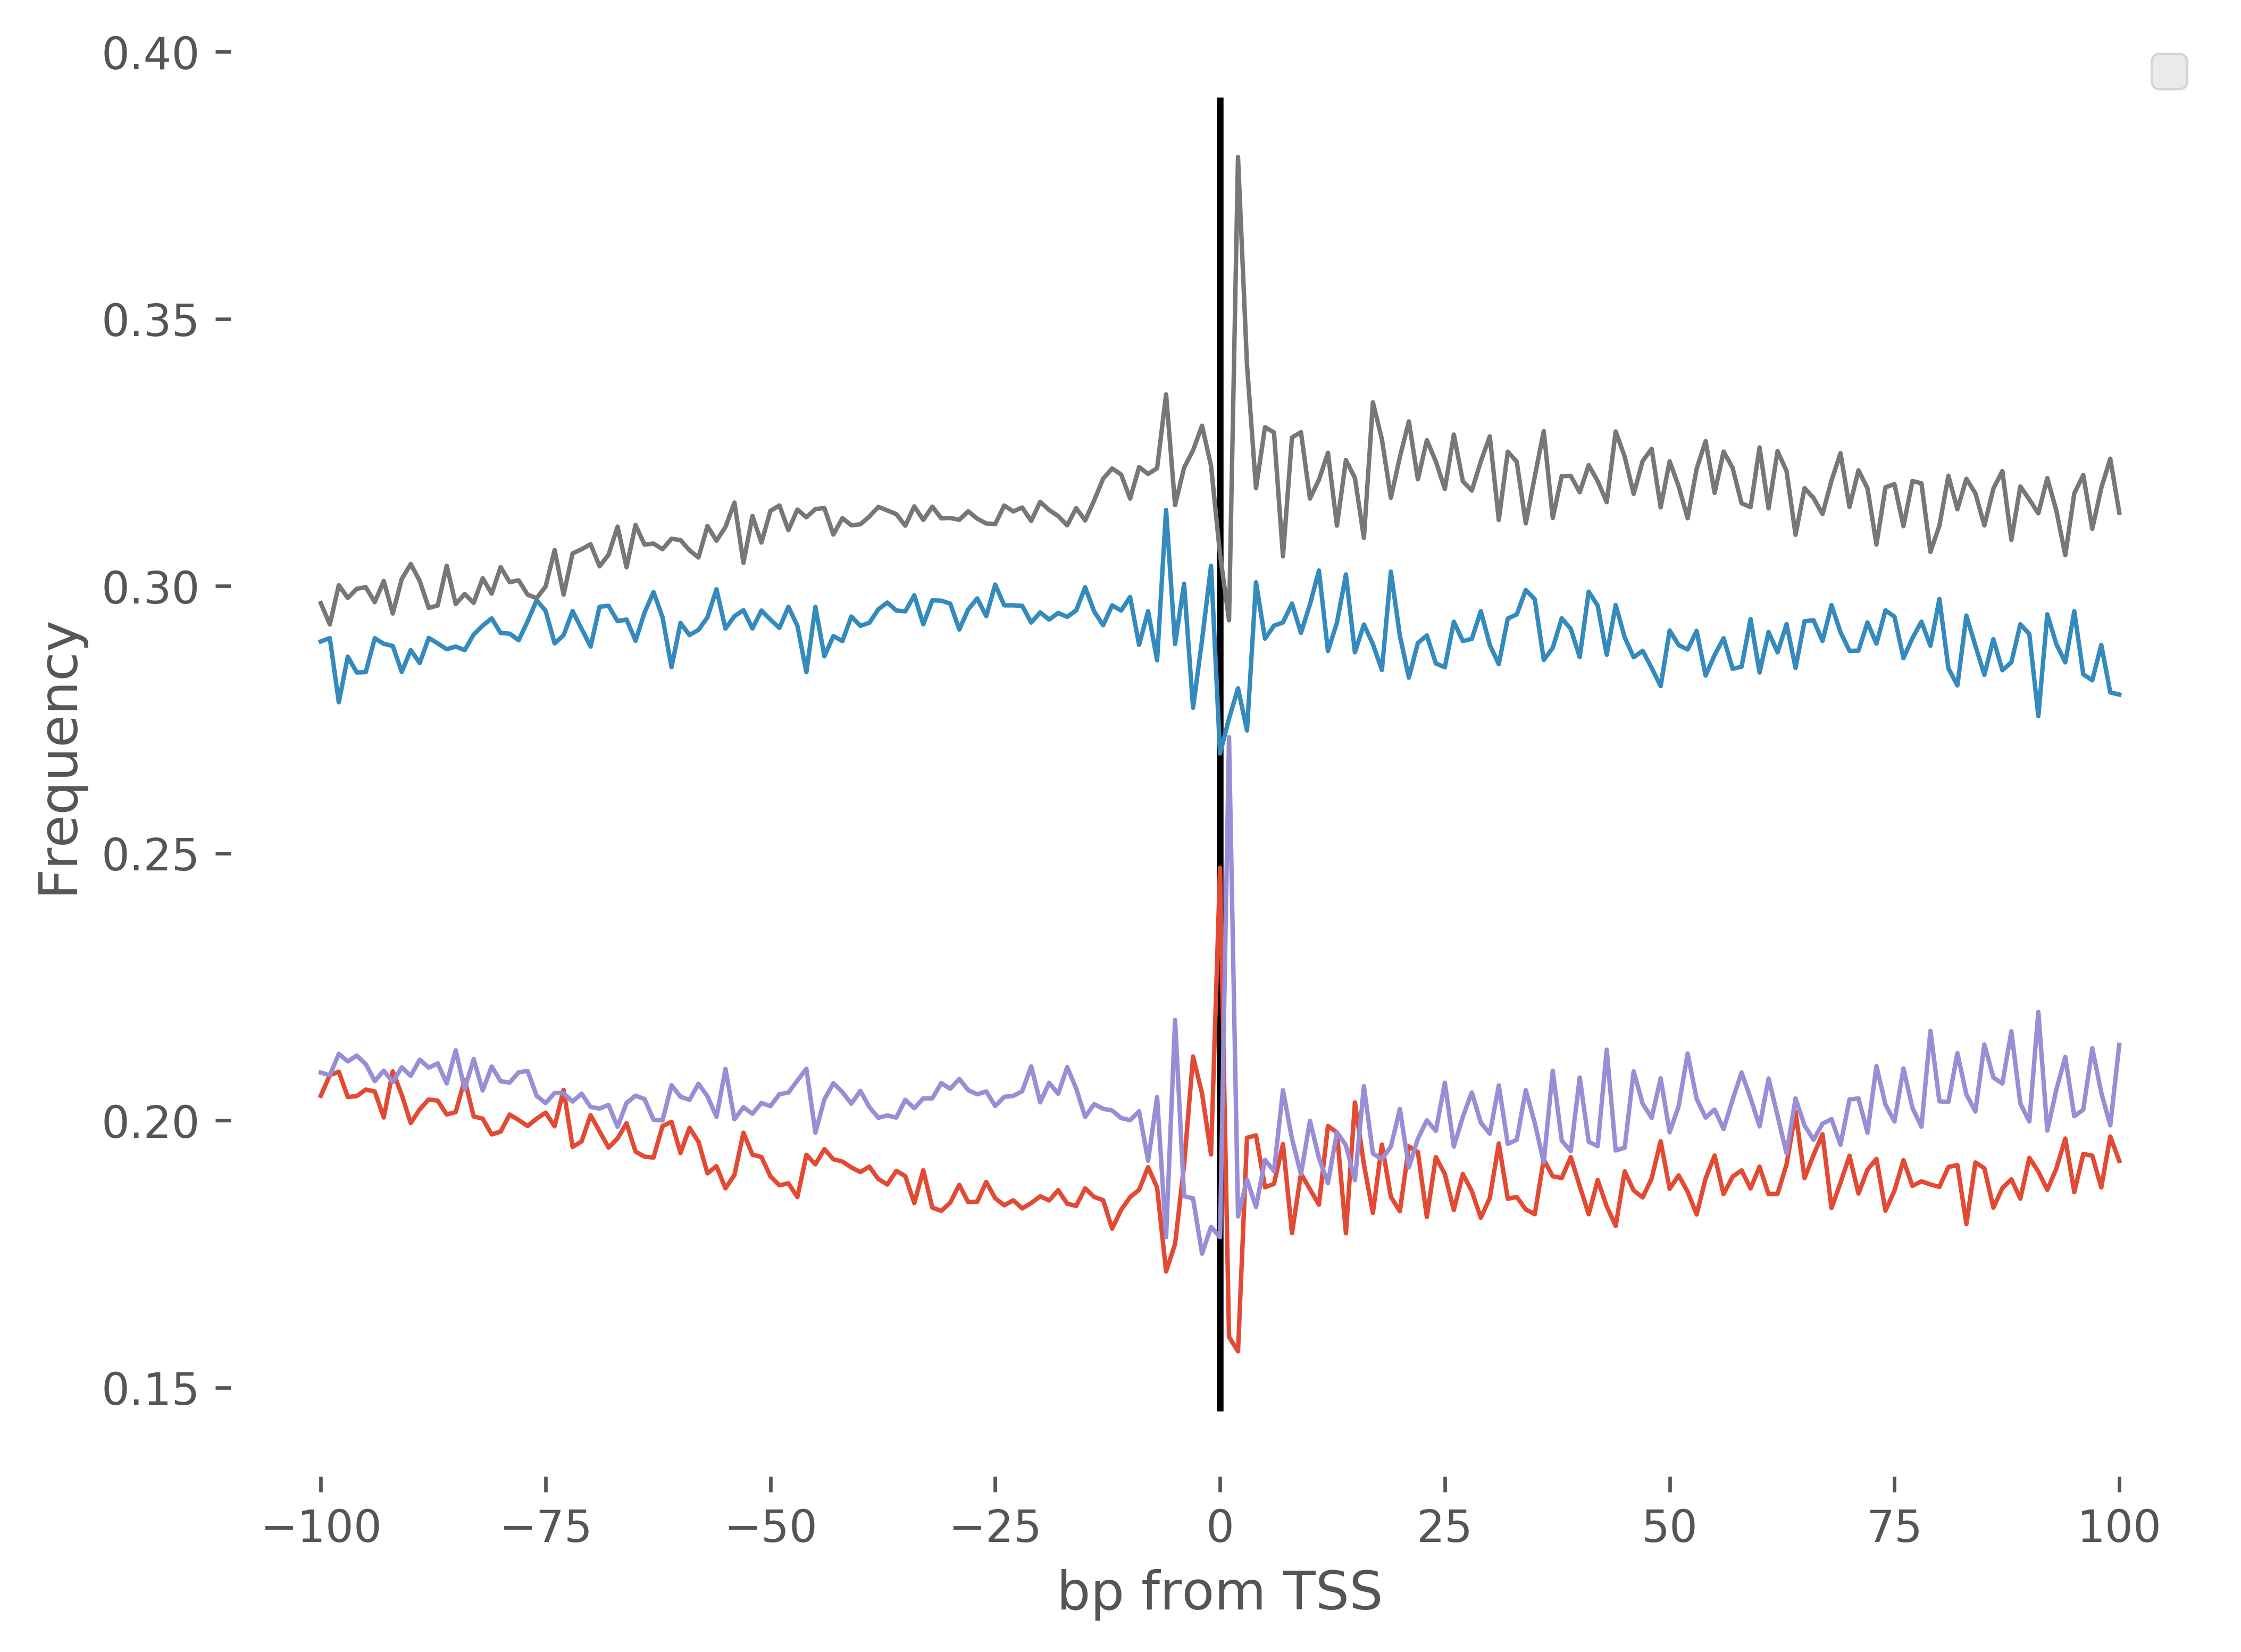

In [8]:
homer_nucleotide(mRNA_bed_file,
    join(nucleotide_out,'gcf_nucfreq_nucl_BED'),
    ref_fa,
    size=200)

## Conclusion: Somehow it looks the same for the mock and the regular bed files

# Run FIMO

In [9]:
motifs_of_interest = ["tata.motif", "inr.motif"]

### First create 150bp mRNA

In [10]:
mRNA_150_bed_outdir = join(nucleotide_out, "refTSS")
mRNA_150_bed_f = join(nucleotide_out, "refTSS", "mRNA_150.bed")
if not os.path.exists(mRNA_150_bed_outdir):
    os.mkdir(mRNA_150_bed_outdir)
shift_bed(mRNA_bed_file, mRNA_150_bed_f, shift=75, is_bed=True)

ref_centered_seq_f = mRNA_150_bed_f.replace('.bed', ".fa")
cmd = f"homerTools extract {mRNA_150_bed_f} {ref_fa} -fa > {ref_centered_seq_f}"
print(cmd)
!{cmd}


homerTools extract gcf_nucleotide/refTSS/mRNA_150.bed /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna -fa > gcf_nucleotide/refTSS/mRNA_150.fa
	Custom genome sequence file: /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna

	Duplicate peak name (NM_001246788.1) - this could potentially cause problems
		Sometimes unavoidable for BED/2DBED formats
		New name for this peak is NM_001246788.1--2
	Extracting sequences from file: /data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna
	Looking for peak sequences in a single file (/data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna)
	Extracting 207 sequences from NW_020822366.1
	Extracting 1 sequences from NW_020822368.1
	Extracting 680 sequences from NW_020822370.1
	Extracting 2 sequences from NW_020822371.1
	Extracting 113 sequences from NW_020822372.1
	Extracting 114 sequences from NW_020822373.1
	Extracting 79 sequences from NW_020822374.1
	Ext

	Extracting 391 sequences from NW_020822630.1
	Extracting 172 sequences from NW_020822632.1
	Extracting 195 sequences from NW_020822634.1
	Extracting 236 sequences from NW_020822636.1
	Extracting 167 sequences from NW_020822638.1
	Extracting 55 sequences from NW_020822641.1
	Extracting 68 sequences from NW_020822642.1
	Extracting 305 sequences from NW_020822643.1
	Extracting 163 sequences from NW_020822644.1
	Extracting 71 sequences from NW_020822645.1
	Extracting 112 sequences from NW_020822646.1
	Extracting 42 sequences from NW_020822647.1
	Extracting 39 sequences from NW_020822648.1
	Extracting 61 sequences from NW_020822649.1
	Extracting 45 sequences from NW_020822650.1
	Extracting 57 sequences from NW_020822651.1
	Extracting 56 sequences from NW_020822652.1
	Extracting 25 sequences from NW_020822653.1
	Extracting 32 sequences from NW_020822654.1
	Extracting 7 sequences from NW_020822655.1
	Extracting 4 sequences from NW_020822656.1
	Extracting 188 sequences from NW_020822657.1
	Ex

	Extracting 1 sequences from NW_020823782.1
	Extracting 1 sequences from NW_020823783.1
	Extracting 2 sequences from NW_020823785.1
	Extracting 5 sequences from NW_020823786.1
	Extracting 1 sequences from NW_020823788.1
	Extracting 5 sequences from NW_020823789.1
	Extracting 1 sequences from NW_020823791.1
	Extracting 1 sequences from NW_020823792.1
	Extracting 2 sequences from NW_020823794.1
	Extracting 3 sequences from NW_020823796.1
	Extracting 3 sequences from NW_020823801.1
	Extracting 3 sequences from NW_020823803.1
	Extracting 4 sequences from NW_020823805.1
	Extracting 1 sequences from NW_020823807.1
	Extracting 5 sequences from NW_020823811.1
	Extracting 1 sequences from NW_020823814.1
	Extracting 1 sequences from NW_020823818.1
	Extracting 9 sequences from NW_020823819.1
	Extracting 3 sequences from NW_020823820.1
	Extracting 3 sequences from NW_020823827.1
	Extracting 1 sequences from NW_020823829.1
	Extracting 2 sequences from NW_020823830.1
	Extracting 1 sequences from NW_

In [11]:
t = time.time()
meme_motifs_dir = join(supplemental,'homer_motifs/MEME_motifs_inr_tata.txt')
out_dir = join(mRNA_150_bed_outdir, "gcf.meme")
#meme_motifs_dir = join("fimo", 'hg38', 'MEME_motifs_short.txt')

cmd = f"fimo --o {out_dir} {meme_motifs_dir} {ref_centered_seq_f} "

print(cmd)
!{cmd}
print(t - time.time())


fimo --o gcf_nucleotide/refTSS/gcf.meme /data/isshamie/TSS/Analysis/supplemental/homer_motifs/MEME_motifs_inr_tata.txt gcf_nucleotide/refTSS/mRNA_150.fa 
Using motif +inr.motif of width 8.
Using motif -inr.motif of width 8.
Computing q-values.
Estimating pi_0 from a uniformly sampled set of 10000 p-values.
Estimating pi_0.
Estimated pi_0=0.952791
Using motif +tata.motif of width 12.
Using motif -tata.motif of width 12.
Computing q-values.
Estimating pi_0 from a uniformly sampled set of 10000 p-values.
Estimating pi_0.
Estimated pi_0=1
-4.755541086196899


In [15]:
shift=75
#motif_f = os.path.join(out_dir, "fimo.tsv")
motif_f = os.path.join(out_dir,"fimo.tsv")
peaks_df_ref = read_bed_file(mRNA_150_bed_f)
peaks_df_ref = peaks_df_ref[~(peaks_df_ref.index.duplicated())]
motifs_df_ref = pd.read_csv(motif_f,sep="\t",comment="#")
#inr = motifs_df[motifs_df["motif_id"] == "inr.motif"]
motifs_df_ref.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,tata.motif,NaN,XM_027429690.1,56,67,-,15.9474,6.850000e-08,0.227,CCTTTTATAGCC
1,tata.motif,NaN,XM_027410061.1,76,87,-,15.9474,6.850000e-08,0.227,CCTTTTATAGCC
2,tata.motif,NaN,XM_027418686.1,108,119,-,15.9474,6.850000e-08,0.227,CCTTTTATAGCC
3,tata.motif,NaN,XM_027393692.1,53,64,-,15.8421,1.370000e-07,0.227,CCTTTTATAGGC
4,tata.motif,NaN,XM_027393690.1,53,64,-,15.8421,1.370000e-07,0.227,CCTTTTATAGGC


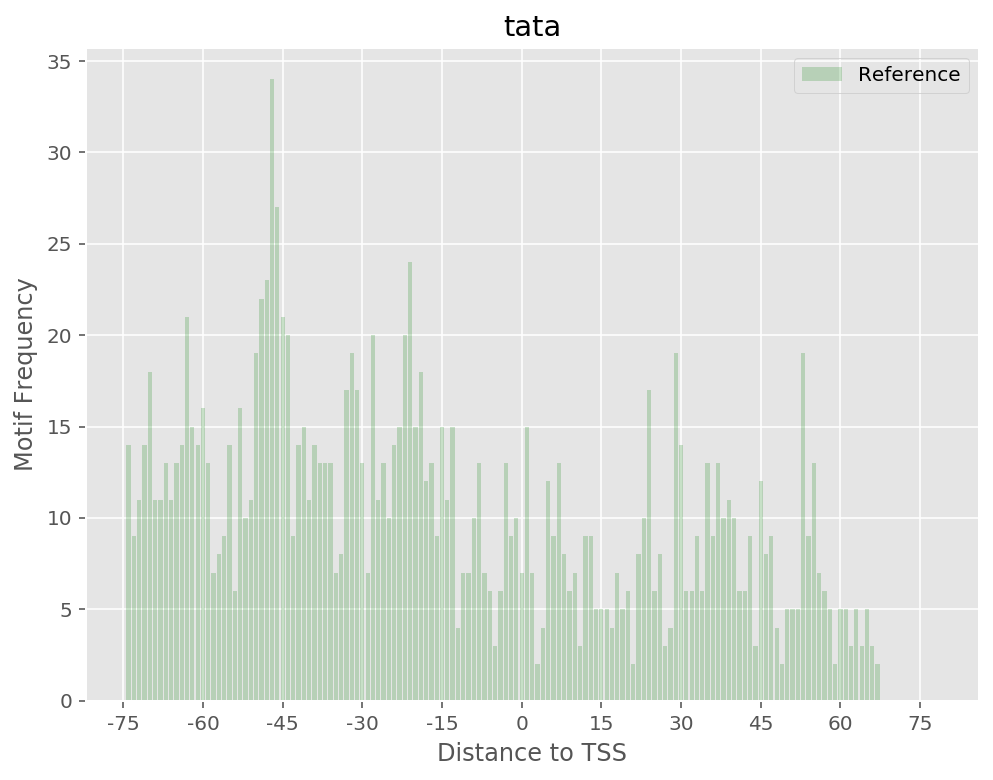

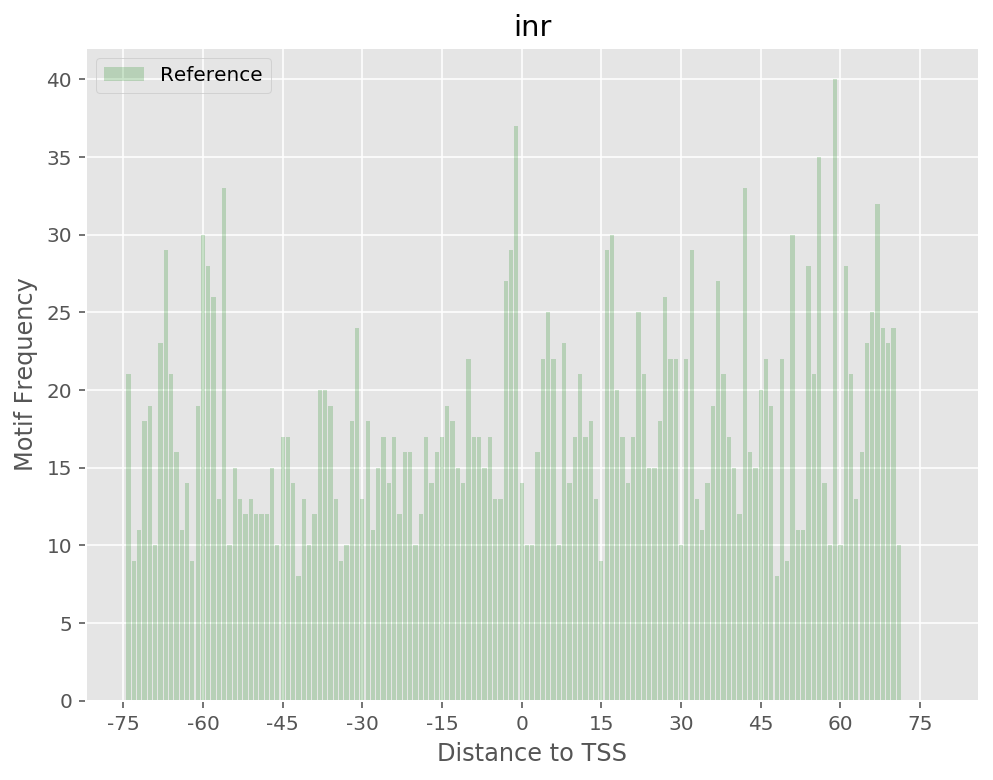

In [19]:
motifs_data = dict()
peak_center=shift
for m in motifs_of_interest:
    name = m.replace(".motif", "")
    curr_ref = motifs_df_ref[motifs_df_ref["motif_id"] ==  m]
    
    #curr = motifs_df.query("motif_id == 'tata.motif' ")
    num_nts = np.max(curr_ref["stop"]) #np.max(curr["stop"] - (curr["start"])+1)
    
    curr_out_neg_ref = motif_analysis.initialize_motif_df(peaks_df_ref.index,seq_len=num_nts)

    curr_out_pos_ref = motif_analysis.initialize_motif_df(peaks_df_ref.index,seq_len=num_nts)

    
    #first_seq = curr_out.columns.values[0]
    first_seq = curr_out_neg_ref.columns.values[0]
    for ind,val in (curr_ref.iterrows()):
        if val["strand"] == "-":
            curr_out_neg_ref.at[val["sequence_name"],first_seq + val["start"] - 1] = True
    for ind,val in (curr_ref.iterrows()):
        if val["strand"] == "+":
            curr_out_pos_ref.at[val["sequence_name"],first_seq + val["start"] - 1] = True  
            
    N = 5
    f,ax = plt.subplots()
    
    y_exp_refseq_centered = np.array(curr_out_pos_ref.sum()) + np.array(curr_out_neg_ref.sum())

    
    motifs_data[name] = pd.DataFrame({"Position":curr_out_neg_ref.columns.values, 
                                      "Motif Counts NCBI RefSeq": y_exp_refseq_centered})

    #motifs_data[name].to_csv(os.path.join(nucleotide_out, name+".csv"), index=False)
    
    
    #ax.bar(x=range(1, len(y_exp)+1), height= y_exp, color="b", alpha=0.4)
    ax.bar(x=range(1, len(y_exp_refseq_centered)+1), height= y_exp_refseq_centered, color="g", alpha=0.2)
    plt.title(name)
    
    ax.set_xlabel("Distance to TSS")
    ax.set_ylabel("Motif Frequency")
    
    ax.set_xticks(np.arange(-1*peak_center,peak_center+1, 15) + peak_center)
    ax.set_xticklabels(np.arange(-1*peak_center,peak_center+1, 15))
    plt.legend(["Reference"]).get_frame().set_facecolor('none')
    #helper_save(os.path.join(nucleotide_out, m.replace(".motif", "") + "_exp_ref" ))
    

------

------

------